# Select study sites from the distribution of RGI glacier areas


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [2]:
# Define paths in directory
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

RGI_path = '/Volumes/GoogleDrive/My Drive/Research/PhD/GIS_data/RGI/'
RGI_fns = ['01_rgi60_Alaska/01_rgi60_Alaska.shp', 
           '02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp']

out_path = '/Volumes/GoogleDrive/My Drive/Research/PhD/snow_cover_mapping/Alexandra_snow_cover_mapping_application/study-sites/'


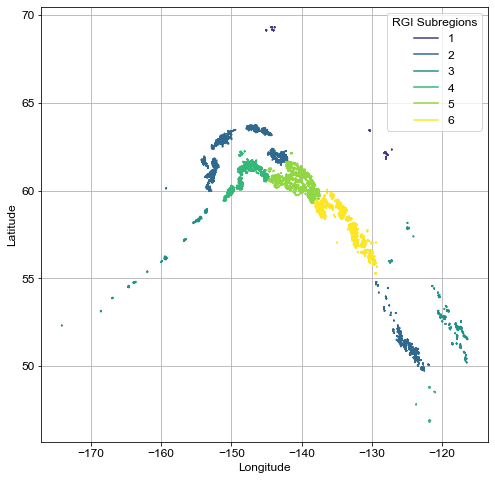

figure saved to file


In [4]:
# Create geopandas.DataFrame for storing RGIs
RGI = gpd.GeoDataFrame()
# Read RGI files
for RGI_fn in RGI_fns:
    file = gpd.read_file(RGI_path + RGI_fn)
    RGI = pd.concat([RGI, file])

# subset to glaciers with area > 5 km^2
RGI_gt5 = RGI.loc[RGI['Area'] > 5].reset_index(drop=True)
# change int data types to float for saving
RGI_gt5[['Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax', 'Status', 'Connect', 
         'Form', 'TermType', 'Surging', 'Linkages']] = RGI_gt5[['Zmin', 'Zmax', 'Zmed', 'Slope', 'Aspect', 'Lmax', 
                                                            'Status', 'Connect', 'Form', 'TermType', 'Surging', 'Linkages']].astype(float)

# grab list of all subregions in dataset
subregions = np.unique(RGI_gt5['O2Region']) 

# plot all sites with color distinguishing subregions
fig1, ax1 = plt.subplots(1, 1, figsize=(8,8))
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
for subregion in subregions:
    RGI_gt5_subregion = RGI_gt5.loc[RGI_gt5['O2Region']==subregion]
    for j in range(0, len(RGI_gt5_subregion)):
        polygon = RGI_gt5_subregion.iloc[j]['geometry']
        if j==0:
            label=subregion
        else:
            label='_nolegend_'
        ax1.plot(*polygon.exterior.xy, color=plt.cm.viridis(int(subregion)/len(subregions)), label=label)
ax1.legend(title='RGI Subregions')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid()
plt.show()

# save figure to file
fig1.savefig(out_path + '../RGI_subregions_1-6.png', facecolor='w', dpi=300)
print('figure saved to file')

RGI Subregion 1
----------
Selected glaciers:
[['RGI60-02.12720' None]
 ['RGI60-02.12947' None]
 ['RGI60-02.13685' None]
 ['RGI60-01.02169' 'Leffingwell Glacier']
 ['RGI60-02.12702' None]]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed fro

selected sites saved to shapefiles in out_path.
[['RGI60-02.13690' None]
 ['RGI60-02.13690' None]]
selected sites saved to shapefiles in out_path.
[['RGI60-02.12721' None]]
selected sites saved to shapefiles in out_path.
[['RGI60-01.02190' None]]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


selected sites saved to shapefiles in out_path.
[['RGI60-02.12468' None]]
selected sites saved to shapefiles in out_path.


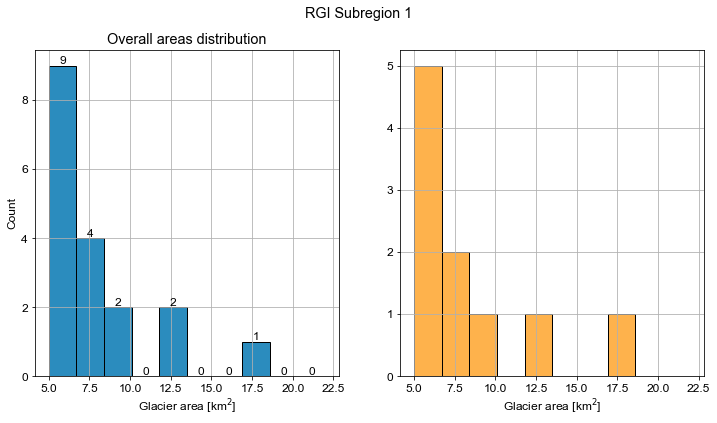

 
RGI Subregion 2
----------
Selected glaciers:
[['RGI60-01.21709' 'Toklat2']
 ['RGI60-02.00412' None]
 ['RGI60-01.15326' None]
 ['RGI60-02.04405' None]
 ['RGI60-01.15548' 'Chetaslina Glacier']
 ['RGI60-01.19399' None]
 ['RGI60-02.05175' None]
 ['RGI60-01.19590' None]
 ['RGI60-01.19394' None]]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed fro

selected sites saved to shapefiles in out_path.


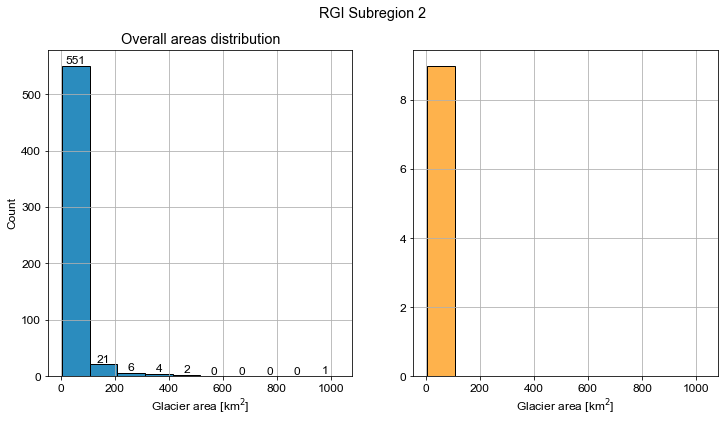

 
RGI Subregion 3
----------
Selected glaciers:
[['RGI60-01.20286' None]
 ['RGI60-01.20324' 'The Knife Creek Glaciers']
 ['RGI60-01.08183' None]
 ['RGI60-02.07595' None]
 ['RGI60-02.08282' None]
 ['RGI60-01.08285' None]
 ['RGI60-02.07601' None]]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed fro

selected sites saved to shapefiles in out_path.
[['RGI60-02.08509' None]
 ['RGI60-01.20235' None]]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


selected sites saved to shapefiles in out_path.
[['RGI60-02.09720' None]]
selected sites saved to shapefiles in out_path.


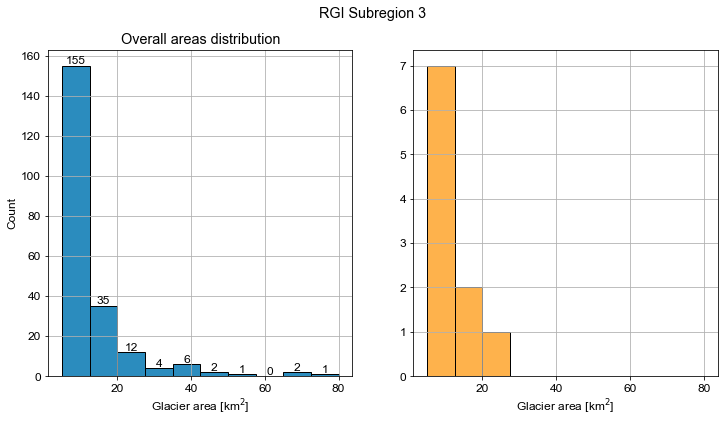

 
RGI Subregion 4
----------
Selected glaciers:
[['RGI60-01.10108' 'Gannett Glacier']
 ['RGI60-01.10928' None]
 ['RGI60-01.10121' 'Serpentine Glacier']
 ['RGI60-01.17910' None]
 ['RGI60-01.10781' None]
 ['RGI60-01.17920' 'Indian Glacier']
 ['RGI60-01.17920' 'Indian Glacier']
 ['RGI60-01.10236' None]
 ['RGI60-02.18775' 'Mazama Glacier WA']]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed fro

selected sites saved to shapefiles in out_path.
[['RGI60-01.10612' 'Yale Glacier']]
selected sites saved to shapefiles in out_path.


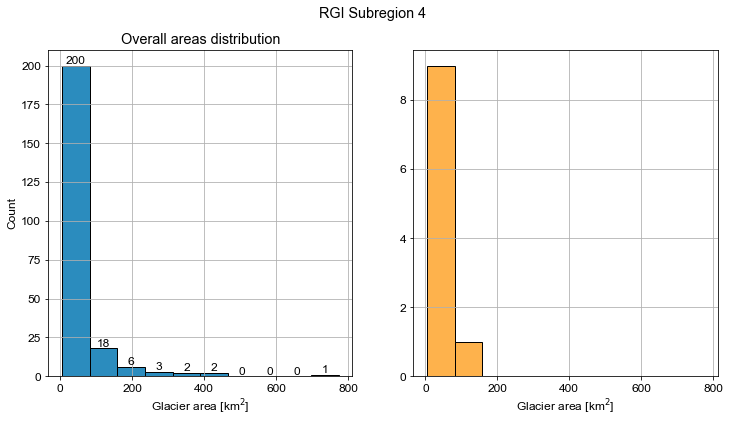

 
RGI Subregion 5
----------
Selected glaciers:
[['RGI60-01.23672' None]
 ['RGI60-01.13958' None]
 ['RGI60-01.16381' None]
 ['RGI60-01.17195' 'Ewe Glacier']
 ['RGI60-01.14325' None]
 ['RGI60-01.22668' None]
 ['RGI60-01.13987' 'Tana Lobe Bremner Glacier']
 ['RGI60-01.16534' None]
 ['RGI60-01.14529' 'Butler Glacier']]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed fro

selected sites saved to shapefiles in out_path.
[['RGI60-01.23641' None]]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


selected sites saved to shapefiles in out_path.


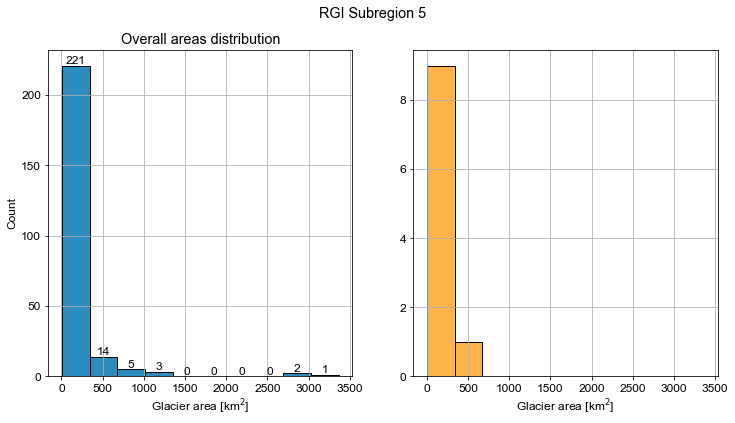

 
RGI Subregion 6
----------
Selected glaciers:
[['RGI60-01.07009' 'Soule Glacier']
 ['RGI60-01.07052' None]
 ['RGI60-01.20630' None]
 ['RGI60-01.21002' None]
 ['RGI60-01.04979' None]
 ['RGI60-01.05343' None]
 ['RGI60-01.23387' None]
 ['RGI60-01.20699' 'Saksaia Glacier']
 ['RGI60-01.05976' None]]


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed fro

selected sites saved to shapefiles in out_path.
[['RGI60-01.03813' 'Flood Glacier']]
selected sites saved to shapefiles in out_path.


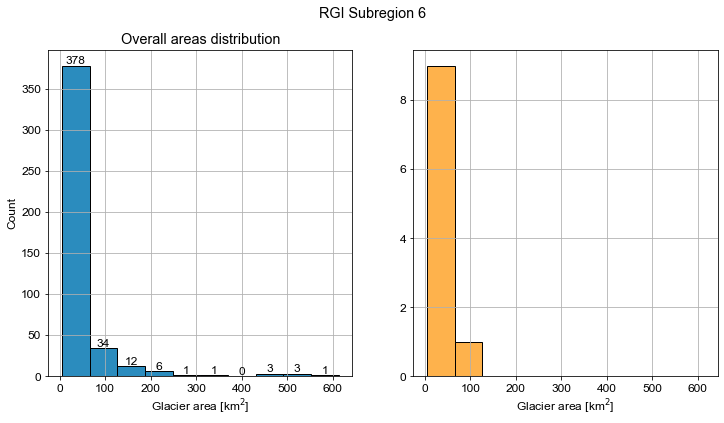

In [5]:
# Select random glaciers from each subregion that represent the overall area distribution
# and save shapefiles to out_path

nsites = 10 # number of sites to include from each region
for subregion in subregions:

    print('RGI Subregion '+subregion)
    print('----------')
    
    # subset dataset to subregion
    RGI_gt5_subregion = RGI_gt5.loc[RGI_gt5['O2Region']==subregion]
    
    # calculate min and max glacier areas in subregion
    area_min = np.nanmin(RGI_gt5_subregion['Area'].values)
    area_max = np.nanmax(RGI_gt5_subregion['Area'].values)
    
    # set up figure
    fig2, ax2 = plt.subplots(1, 2, figsize=(12, 6))
    # calculate histogram of overall distribution
    counts, edges, bars = ax2[0].hist(RGI_gt5_subregion['Area'].values, bins=10, 
                                  range=[np.round(area_min), np.round(area_max)],
                                    edgecolor='k', facecolor='#2b8cbe')
    
    # randomly select nsites using the histogram bins
    counts_selected = np.zeros(len(counts), dtype=int)
    print('Selected glaciers:')
    for i in range(0,len(counts)):
        # identify number of sites to select from each bin
        counts_selected[i] = int(np.round(counts[i] / len(RGI_gt5_subregion) * nsites))
        if counts_selected[i] > 0:
            # subset sites to those within that area bin
            RGI_gt5_subregion_bin = RGI_gt5_subregion.loc[(RGI_gt5_subregion['Area']>edges[i]) & 
                                                          (RGI_gt5_subregion['Area']<edges[i+1])]
            # generate counts_selected random numbers
            Iselected = np.random.randint(low=0, high=len(RGI_gt5_subregion_bin), size=counts_selected[i])
            RGI_selected = RGI_gt5_subregion_bin.iloc[Iselected]
            print(RGI_selected[['RGIId', 'Name']].values)
            # save selected study sites to file
            for j in range(0,len(RGI_selected)):
                RGI_select = gpd.GeoDataFrame(RGI_selected.iloc[j]).transpose().reset_index(drop=True)
                RGIId = RGI_select['RGIId'].values[0]
                out_fn = RGIId + '.shp'
                # make folder for study site
                if os.path.exists(out_path + RGIId)==False:
                    os.mkdir(out_path + RGIId)
                # save file in folder
                RGI_select.to_file(out_path + RGIId + '/' + out_fn)  
                # plot RGI outlines on figure 1
                # polygon = RGI_select['geometry'].values
                # if count==0:
                #     label='Selected study sites'
                # else:
                #     label='_nolegend_'
                # ax1.plot(*polygon.exterior.xy, color='k', label=label)
                # count+=1
            print('selected sites saved to shapefiles in out_path.')
        
    # adjust axes
    ax2[0].bar_label(bars)
    ax2[0].set_xlabel('Glacier area [km$^2$]')
    ax2[0].set_ylabel('Count')
    ax2[0].set_title('Overall areas distribution')
    ax2[0].grid()
    # plot histogram for selected glaciers
    bin_centers = np.array([(edges[i+1]-edges[i])/2+edges[i] for i in range(0, len(edges)-1)])
    ax2[1].bar(bin_centers, counts_selected, width=edges[1]-edges[0], edgecolor='k', facecolor='#feb24c')
    ax2[1].set_xlabel('Glacier area [km$^2$]')
    ax2[1].grid()
    fig2.suptitle('RGI Subregion '+subregion)
    plt.show()
    
    print(' ')
    